<a href="https://colab.research.google.com/github/kamilakhtar015/Machine-Learning---Concepts-GSU-/blob/main/UrbanSceneSegmentation_DeepLabV3_Cityscapes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

balraj98_cityscapes_pix2pix_dataset_path = kagglehub.dataset_download('balraj98/cityscapes-pix2pix-dataset')
kamilakhtar_picture_01_path = kagglehub.dataset_download('kamilakhtar/picture-01')
kamilakhtar_talking_man_picture_path = kagglehub.dataset_download('kamilakhtar/talking-man-picture')
kamilakhtar_deeplabv3_model_other_default_1_path = kagglehub.model_download('kamilakhtar/deeplabv3-model/Other/default/1')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cityscapes-pix2pix-dataset/metadata.csv
/kaggle/input/cityscapes-pix2pix-dataset/val/208.jpg
/kaggle/input/cityscapes-pix2pix-dataset/val/473.jpg
/kaggle/input/cityscapes-pix2pix-dataset/val/333.jpg
/kaggle/input/cityscapes-pix2pix-dataset/val/45.jpg
/kaggle/input/cityscapes-pix2pix-dataset/val/369.jpg
/kaggle/input/cityscapes-pix2pix-dataset/val/56.jpg
/kaggle/input/cityscapes-pix2pix-dataset/val/89.jpg
/kaggle/input/cityscapes-pix2pix-dataset/val/20.jpg
/kaggle/input/cityscapes-pix2pix-dataset/val/275.jpg
/kaggle/input/cityscapes-pix2pix-dataset/val/212.jpg
/kaggle/input/cityscapes-pix2pix-dataset/val/239.jpg
/kaggle/input/cityscapes-pix2pix-dataset/val/58.jpg
/kaggle/input/cityscapes-pix2pix-dataset/val/150.jpg
/kaggle/input/cityscapes-pix2pix-dataset/val/6.jpg
/kaggle/input/cityscapes-pix2pix-dataset/val/109.jpg
/kaggle/input/cityscapes-pix2pix-dataset/val/149.jpg
/kaggle/input/cityscapes-pix2pix-dataset/val/187.jpg
/kaggle/input/cityscapes-pix2pix-dataset/val/436.jpg

In [ ]:
print("Let Begin the Segmentation")

Let Begin the Segmentation


In [ ]:
# Notebook Title
# Urban Scene Segmentation Using DeepLabV3+ on Cityscapes Dataset

import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from IPython.display import display

dataset_path = '/kaggle/input/cityscapes-dataset'

# Check the directory structure
for root, dirs, files in os.walk(dataset_path):
    print(root)
    for file in files[:5]:
        print('  └──', file)
    print()


In [ ]:
data_dir = "/kaggle/input/cityscapes-pix2pix-dataset"

train_dir = os.path.join(data_dir, 'train')
val_dir= os.path.join(data_dir, 'val')

print("Sample training images")
train_files = sorted(os.listdir(train_dir))
for file in train_files[:6]:
    print(file)

print("___________________________________________________________")

print("Training Dataset length " , len(train_files))
test_files = os.listdir(val_dir)
print("Test Dataset length " , len(test_files))

Sample training images
1.jpg
10.jpg
100.jpg
1000.jpg
1001.jpg
1002.jpg
___________________________________________________________
Training Dataset length  2975
Test Dataset length  500


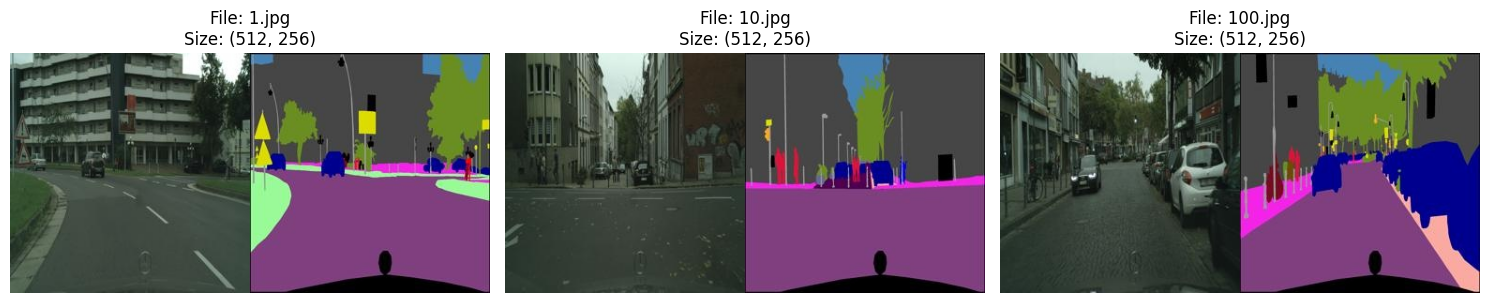

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

train_dir = '/kaggle/input/cityscapes-pix2pix-dataset/train'

# Load a few samples
sample_files = sorted(os.listdir(train_dir))[:3]

plt.figure(figsize=(15, 5))
for idx, file in enumerate(sample_files):
    path = os.path.join(train_dir, file)
    img = Image.open(path)

    plt.subplot(1, 3, idx+1)
    plt.imshow(img)
    plt.title(f"File: {file}\nSize: {img.size}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# Data Preprocessing

### Split Image into Input and Mask

In [ ]:
# Split image into Input and Mask
from PIL import Image
import numpy as np

def load_image_and_mask(path):
    """
    Loads a 512x256 pix2pix image, splits it into input (RGB) and mask (RGB)
    """
    img = Image.open(path)
    img_array = np.array(img)

    # Split into input and mask (split along width)
    input_img = img_array[:, :256,:] / 255  #  Normalize to [0, 1]
    mask_img = img_array[: ,256:, :]        # Keep as raw labels

    return input_img, mask_img

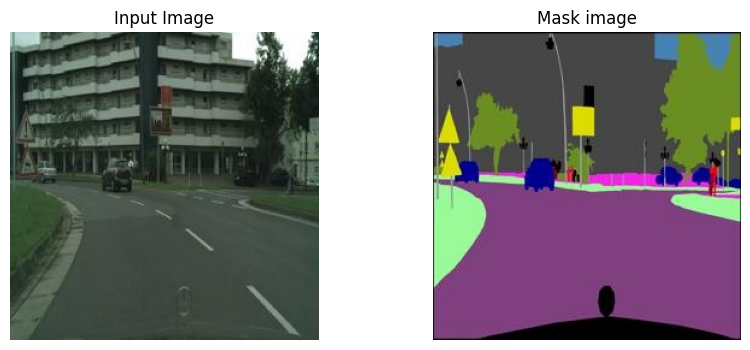

In [ ]:
# Preview input and mask split
sample_file = os.path.join(train_dir, '1.jpg')

input_img, mask_img = load_image_and_mask(sample_file)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(input_img)
plt.title("Input Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask_img)
plt.title("Mask image")
plt.axis("off")

plt.show()

### Define Color-to-Class Mapping

In [ ]:
# Define a color -> class ID mapping (you can expand this based on visual inspection)
COLOR_MAP = {
    (128, 64, 128): 0,   # road
    (244, 35, 232): 1,   # sidewalk
    (70, 70, 70): 2,     # building
    (102, 102, 156): 3,  # wall
    (190, 153, 153): 4,  # fence
    (153, 153, 153): 5,  # pole
    (250, 170, 30): 6,   # traffic light
    (220, 220, 0): 7,    # traffic sign
    (107, 142, 35): 8,   # vegetation
    (0, 0, 142): 9       # car
}


### Convert RGB Mask to Class Index Mask

In [ ]:
def rgb_to_class(mask_img):
    """
    Converts RGB mask to a single-channel mask of class IDs.
    """
    h, w, _ = mask_img.shape
    class_mask = np.zeros((h, w), dtype=np.uint8)  # ✅ Fix typo: np.uint8

    for color, class_id in COLOR_MAP.items():
        matches = np.all(mask_img == color, axis=-1)
        class_mask[matches] = class_id

    return class_mask


### Final Preprocessing Function

In [ ]:
def preprocess_image(file_path):
    input_img, mask_img = load_image_and_mask(file_path)
    class_mask = rgb_to_class(mask_img)
    return input_img, class_mask

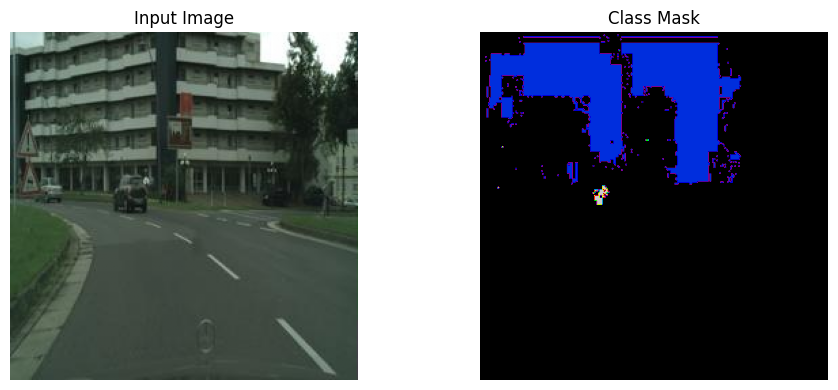

In [ ]:
test_file = os.path.join(train_dir, "1.jpg")

input_img, mask = preprocess_image(test_file)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(input_img)
plt.title("Input Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="nipy_spectral")
plt.title("Class Mask")
plt.axis("off")

plt.tight_layout()
plt.show()

# Build the Dataset Loader

### tf.data.Dataset Pipeline

In [ ]:
import tensorflow as tf

def tf_preprocess(file_path):
    def _py_function(path):
        path_str = path.numpy().decode()
        input_img, mask = preprocess_image(path_str)
        return input_img, mask

    image, mask = tf.py_function(_py_function, [file_path], [tf.float32, tf.uint8])
    image.set_shape([256, 256, 3])
    mask.set_shape([256, 256])

    return image, mask

def get_dataset(folder_path, batch_size=8, shuffle=True):
    image_files = sorted([os.path.join(folder_path, fname) for fname in os.listdir(folder_path)])

    dataset = tf.data.Dataset.from_tensor_slices(image_files)
    dataset = dataset.map(tf_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=100)

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


### Create Train & Validation Datasets

In [ ]:
train_dataset = get_dataset(train_dir, batch_size=8)
val_dataset = get_dataset(val_dir, batch_size=8, shuffle=False)

# Check one batch
for images, masks in train_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)


Image batch shape: (8, 256, 256, 3)
Mask batch shape: (8, 256, 256)


# Model Architecture — DeepLabV3+

### Set Number of Classes

In [ ]:
NUM_CLASSES = len(COLOR_MAP)

In [ ]:
def DeeplabV3Plus(input_shape=(256, 256, 3), num_classes=10):
    base_model = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)

    # Use intermediate feature map
    x = base_model.get_layer("conv4_block23_out").output  # 1/16 resolution
    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)

    # ASPP-like bottleneck
    x = layers.Conv2D(256, 1, dilation_rate=1, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)

    # Upsample to 1/4 resolution
    x = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)

    # Final decoder layers
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)

    # Output layer
    outputs = layers.Conv2D(num_classes, 1, activation="softmax")(x)

    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model


In [ ]:
model = DeeplabV3Plus(input_shape=(256, 256, 3), num_classes=NUM_CLASSES)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 30,383,882 (115.91 MB)

 Trainable params: 30,299,786 (115.58 MB)

 Non-trainable params: 84,096 (328.50 KB)

# Define Callbacks

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

checkpoint_cb = ModelCheckpoint(
    "best_model.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

callbacks = [checkpoint_cb, reduce_lr_cb]


### Train the Model

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.8433 - loss: 1.2721
Epoch 1: val_loss improved from inf to 0.72213, saving model to best_model.keras
372/372 ━━━━━━━━━━━━━━━━━━━━ 173s 462ms/step - accuracy: 0.8435 - loss: 1.2712 - val_accuracy: 0.8804 - val_loss: 0.7221 - learning_rate: 1.0000e-04
Epoch 2/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.9446 - loss: 0.4901
Epoch 2: val_loss improved from 0.72213 to 0.47303, saving model to best_model.keras
372/372 ━━━━━━━━━━━━━━━━━━━━ 120s 319ms/step - accuracy: 0.9446 - loss: 0.4899 - val_accuracy: 0.9113 - val_loss: 0.4730 - learning_rate: 1.0000e-04
Epoch 3/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.9524 - loss: 0.2676
Epoch 3: val_loss improved from 0.47303 to 0.32628, saving model to best_model.keras
372/372 ━━━━━━━━━━━━━━━━━━━━ 119s 317ms/step - accuracy: 0.9524 - loss: 0.2675 - val_accuracy: 0.9458 - val_loss: 0.3263 - learning_rate: 1.0000e-04
Epoch 4/20
372/372 ━━━━━━━━━━━━━━━━━━━

# Prediction and Visualization

### Define Color Decode Function

In [ ]:
def decode_segmentation(mask):
    """
    Converts a 2D class index mask to RGB for visualization.
    """
    h, w = mask.shape
    rgb_mask = np.zeros((h, w, 3), dtype=np.uint8)

    for color, class_id in COLOR_MAP.items():
        rgb_mask[mask == class_id] = color

    return rgb_mask


### Predict on One Batch from Validation Set

In [ ]:
# Grab one batch from validation set
for images, true_masks in val_dataset.take(1):
    preds = model.predict(images)
    break

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


### Visualize Predictions

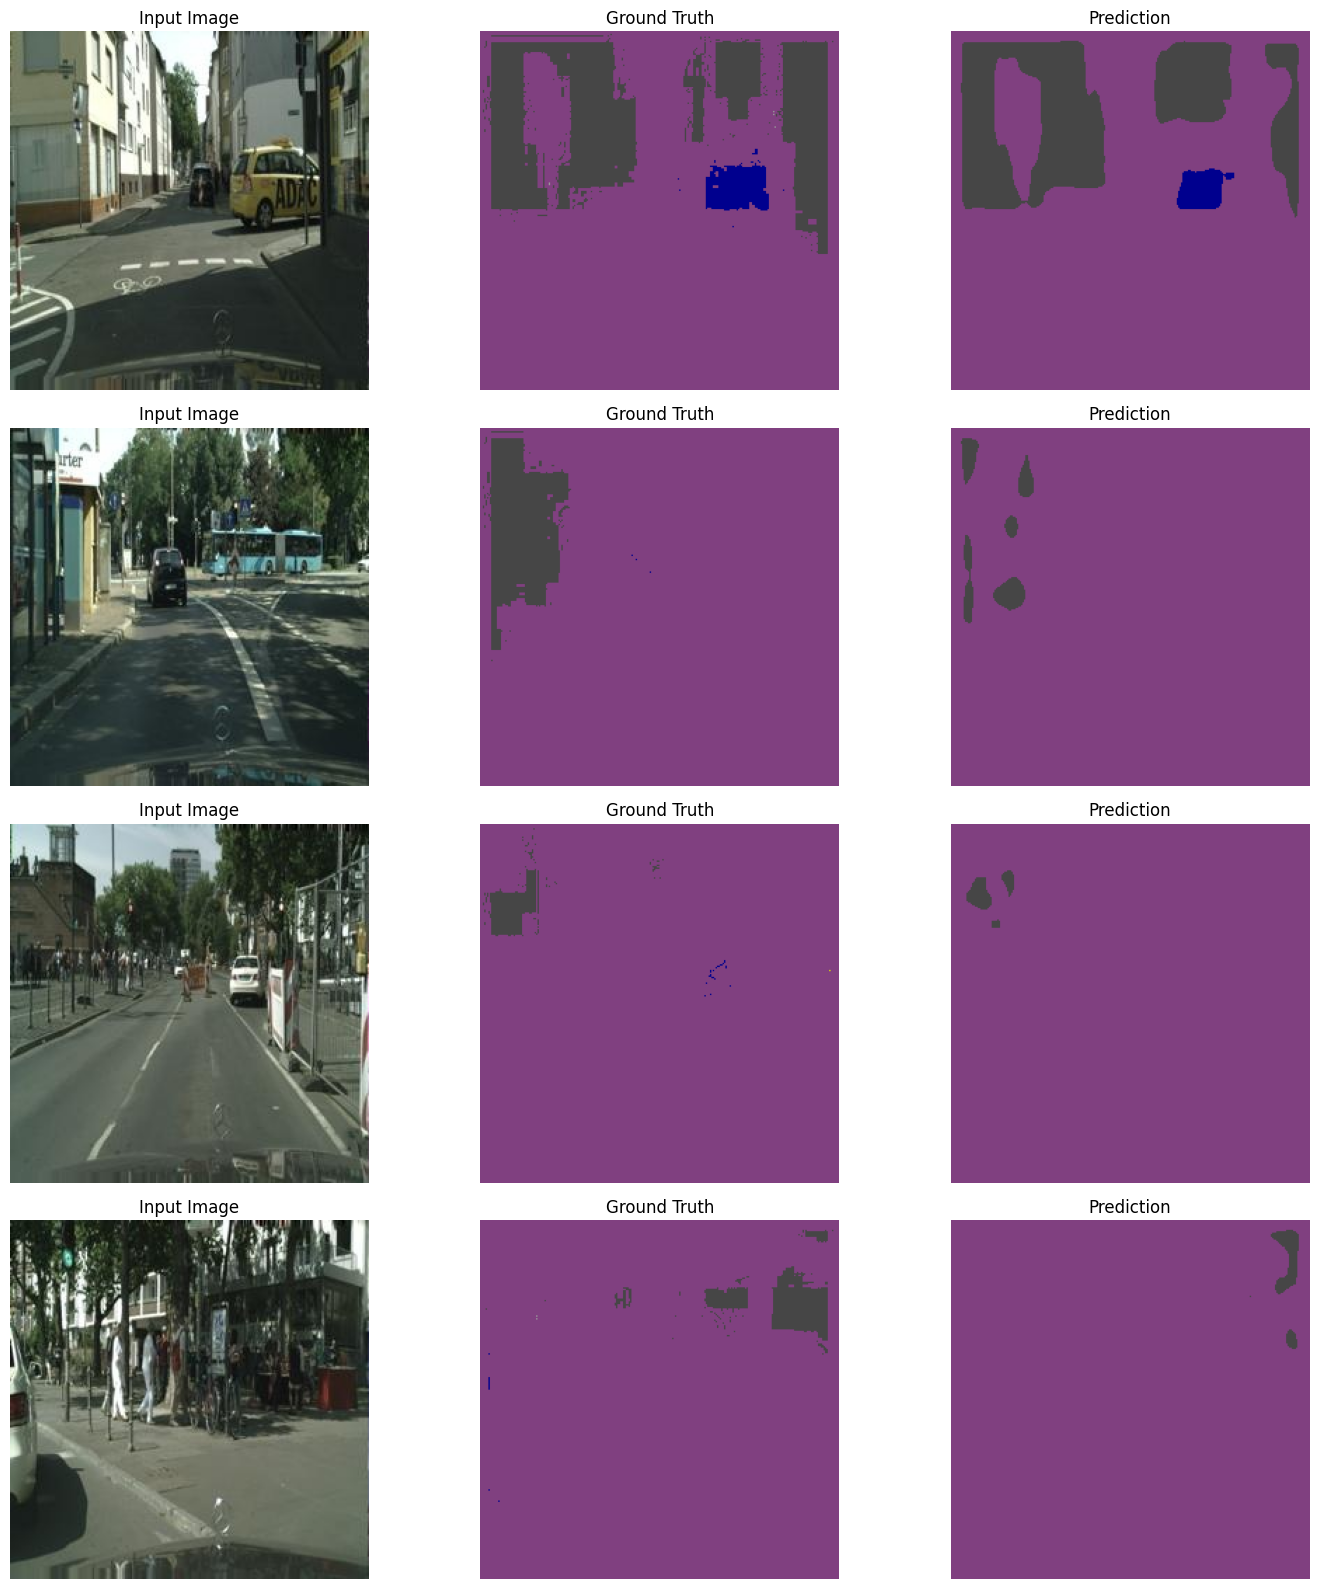

In [ ]:
num_samples = 4  # Show 4 predictions

plt.figure(figsize=(15, num_samples * 4))

for i in range(num_samples):
    pred_mask = tf.argmax(preds[i], axis=-1).numpy()
    pred_rgb = decode_segmentation(pred_mask)
    true_rgb = decode_segmentation(true_masks[i].numpy())

    # Original
    plt.subplot(num_samples, 3, i*3 + 1)
    plt.imshow(images[i].numpy())
    plt.title("Input Image")
    plt.axis("off")

    # Ground Truth
    plt.subplot(num_samples, 3, i*3 + 2)
    plt.imshow(true_rgb)
    plt.title("Ground Truth")
    plt.axis("off")

    # Predicted
    plt.subplot(num_samples, 3, i*3 + 3)
    plt.imshow(pred_rgb)
    plt.title("Prediction")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
model.save("road_scene_segmenter.keras")

In [ ]:
import tensorflow as tf

model_path = "/kaggle/input/deeplabv3-model/other/default/1/road_scene_segmenter.keras"
model = tf.keras.models.load_model(model_path)

print("Model loaded successfully!")


Model loaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


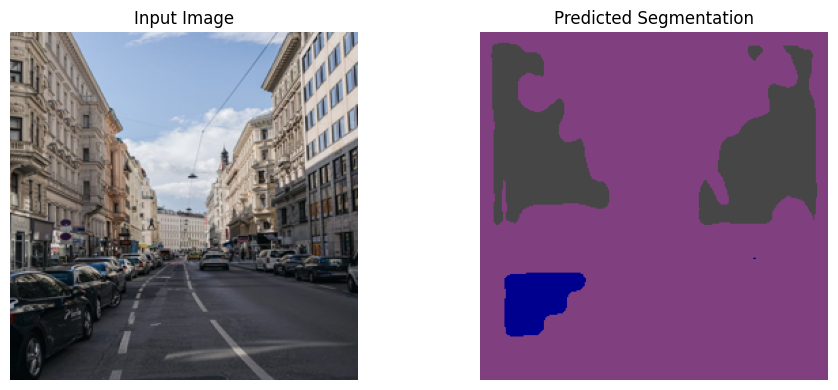

In [ ]:
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Path to your uploaded image
image_path = "/kaggle/input/picture-01/free-photo-of-cars-parked-on-street-in-city.jpeg"

# Function to convert class index mask to RGB color
def decode_segmentation(mask):
    h, w = mask.shape
    rgb_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for color, class_id in COLOR_MAP.items():
        rgb_mask[mask == class_id] = color
    return rgb_mask

# Function to preprocess and predict segmentation
def predict_image(image_path):
    # Load and resize image
    img = Image.open(image_path).convert("RGB").resize((256, 256))
    img_np = np.array(img) / 255.0  # Normalize
    img_input = np.expand_dims(img_np, axis=0)

    # Predict
    pred = model.predict(img_input)[0]
    pred_mask = tf.argmax(pred, axis=-1).numpy()
    pred_rgb = decode_segmentation(pred_mask)

    # Show result
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_rgb)
    plt.title("Predicted Segmentation")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Run prediction on the uploaded image
predict_image(image_path)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


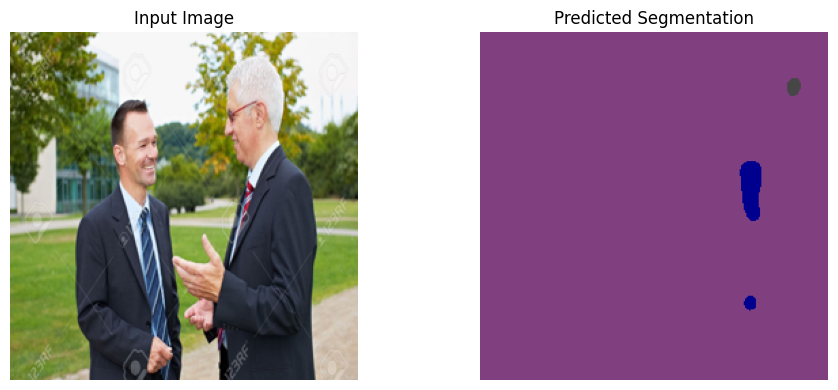

In [ ]:
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Path to your uploaded image
image_path = "/kaggle/input/talking-man-picture/talking  men.jpg"

# Function to convert class index mask to RGB color
def decode_segmentation(mask):
    h, w = mask.shape
    rgb_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for color, class_id in COLOR_MAP.items():
        rgb_mask[mask == class_id] = color
    return rgb_mask

# Function to preprocess and predict segmentation
def predict_image(image_path):
    # Load and resize image
    img = Image.open(image_path).convert("RGB").resize((256, 256))
    img_np = np.array(img) / 255.0  # Normalize
    img_input = np.expand_dims(img_np, axis=0)

    # Predict
    pred = model.predict(img_input)[0]
    pred_mask = tf.argmax(pred, axis=-1).numpy()
    pred_rgb = decode_segmentation(pred_mask)

    # Show result
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_rgb)
    plt.title("Predicted Segmentation")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Run prediction on the uploaded image
predict_image(image_path)



# _________________________________________
# A Complete Different Approach

# Dataset Setup

In [ ]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

    
Initialization --> Loads dataset info, sets transforms

Image Splitting	 --> Each .jpg is split into (input, mask)

Transformations	--> Resize + Normalize image, Resize mask

Output	-->  Returns input image and corresponding class-wise mask tensor

In [ ]:
class CityscapesPix2PixDataset(Dataset):
    def __init__(self, root_dir, mode='train', transform=None, image_size=(256, 512)):
        self.mode = mode
        self.root_dir = os.path.join(root_dir, mode)
        self.file_names = sorted(os.listdir(self.root_dir))
        self.transform = transform
        self.image_size = image_size  # (H, W)

        # Basic image transform for the input RGB image
        self.img_transform = transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                                 std=[0.229, 0.224, 0.225])   # ImageNet std
        ])

        # Mask should be resized and converted to tensor (not normalized!)
        self.mask_transform = transforms.Compose([
            transforms.Resize(self.image_size, interpolation=Image.NEAREST),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_path = os.path.join(self.root_dir, self.file_names[idx])
        full_image = Image.open(file_path).convert("RGB")

        # Split into input image and mask
        w, h = full_image.size
        input_image = full_image.crop((0, 0, w // 2, h))
        label_mask = full_image.crop((w // 2, 0, w, h))

        # Apply transforms
        input_tensor = self.img_transform(input_image)
        mask_tensor = self.mask_transform(label_mask)

        # Convert mask from [0,1] float tensor to int64 class tensor
        # mask_tensor = (mask_tensor[0] * 255).long()
        mask_tensor = (mask_tensor[0] * 255).long()
        mask_tensor = torch.clamp(mask_tensor, 0, 18)  # limit class values to [0, 18]


        return input_tensor, mask_tensor


Load Cityscapes pix2pix-format data

Create custom PyTorch Dataset class

Apply transforms & return tensor pairs

Test with DataLoader & visualize samples

Confirm that everything works visually

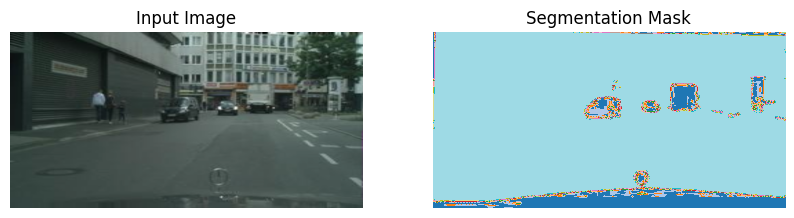

In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

dataset = CityscapesPix2PixDataset(root_dir="/kaggle/input/cityscapes-pix2pix-dataset", mode="train", image_size=(384, 768))

dataloader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    drop_last=True  # ✅ prevents last batch from being size 1
)


# dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

def show_sample(input_tensor, mask_tensor):
    input_img = input_tensor.clone().detach()
    input_img = input_img.permute(1, 2, 0).numpy()
    input_img = input_img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
    input_img = (input_img * 255).astype("uint8")

    # Mask as grayscale image (each pixel = class id)
    mask = mask_tensor.numpy()

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(input_img)
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='tab20')  # 'tab20' helps distinguish classes
    plt.title("Segmentation Mask")
    plt.axis('off')

    plt.show()

for inputs, masks in dataloader:
    show_sample(inputs[0], masks[0])
    break


# Model Architecture -- Building DeeplabV3+ Model

In [ ]:
def get_deeplab_model(num_classes=19):
    model = models.deeplabv3_resnet50(pretrained=True)

    # Replace final classifier for 19 classes
    model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)

    # Disable aux_classifier to avoid 21-class mismatch
    model.aux_classifier = None

    return model


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_deeplab_model(num_classes=19).to(device)
print("Model is working")

Model is working


In [ ]:
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

# Loss Function, Optimizer & Scheduler

We’ll use CrossEntropyLoss, which is standard for multi-class segmentation:

This loss:

* Compares predicted logits for each pixel with the true class label.

* Ignores the need for one-hot encoding.



In [ ]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss()


### Optimizer
We’ll use AdamW, which is good for modern architectures

In [ ]:
import torch.optim as optim

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)


### Scheduler


In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR

scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)


# Train the Model

In [ ]:
from tqdm.notebook import tqdm  # tqdm for Jupyter/Kaggle Notebook

def train_model(model, dataloader, criterion, optimizer, scheduler, device, num_epochs=5):
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        loop = tqdm(dataloader, leave=False, total=len(dataloader), desc=f"Epoch [{epoch+1}/{num_epochs}]")

        for batch_idx, (images, masks) in enumerate(loop):
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)['out']
            loss = criterion(outputs, masks)

            # Backward pass
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Update tqdm bar with current loss
            loop.set_postfix(loss=loss.item())

        # Step the scheduler
        scheduler.step()

        avg_loss = running_loss / len(dataloader)
        print(f"✅ Epoch {epoch+1}/{num_epochs} completed — Avg Loss: {avg_loss:.4f}")


In [ ]:
train_model(model, dataloader, criterion, optimizer, scheduler, device, num_epochs=5)

Epoch [1/5]:   0%|          | 0/1487 [00:00<?, ?it/s]

✅ Epoch 1/5 completed — Avg Loss: 0.4863


Epoch [2/5]:   0%|          | 0/1487 [00:00<?, ?it/s]

✅ Epoch 2/5 completed — Avg Loss: 0.2524


Epoch [3/5]:   0%|          | 0/1487 [00:00<?, ?it/s]

✅ Epoch 3/5 completed — Avg Loss: 0.2332


Epoch [4/5]:   0%|          | 0/1487 [00:00<?, ?it/s]

✅ Epoch 4/5 completed — Avg Loss: 0.2173


Epoch [5/5]:   0%|          | 0/1487 [00:00<?, ?it/s]

✅ Epoch 5/5 completed — Avg Loss: 0.2045


In [ ]:
torch.save(model.state_dict(), "deeplabv3_cityscapes.pth")

In [ ]:
model.load_state_dict(torch.load("deeplabv3_cityscapes.pth"))
model.eval()  # Set to inference mode

<ipython-input-35-535a868f2828>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("deeplabv3_cityscapes.pth"))


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

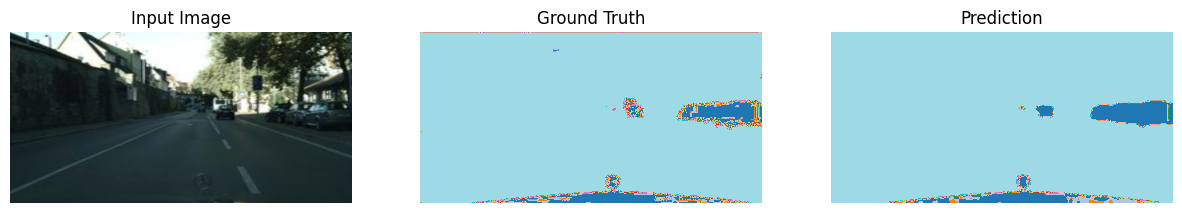

In [ ]:
model.eval()

val_dataset = CityscapesPix2PixDataset(
    root_dir="/kaggle/input/cityscapes-pix2pix-dataset",
    mode="val",
    image_size=(384, 768)
)

val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

import matplotlib.pyplot as plt
import numpy as np

def visualize_prediction(input_tensor, mask_tensor, pred_tensor):
    input_img = input_tensor.permute(1, 2, 0).cpu().numpy()
    input_img = input_img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    input_img = (input_img * 255).astype("uint8")

    mask = mask_tensor.cpu().numpy()
    pred = pred_tensor.cpu().numpy()

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(input_img)
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='tab20')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred, cmap='tab20')
    plt.title("Prediction")
    plt.axis('off')
    plt.show()

# Run on one random validation image
with torch.no_grad():
    for input_tensor, mask_tensor in val_loader:
        input_tensor = input_tensor.to(device)
        output = model(input_tensor)["out"]
        pred_tensor = torch.argmax(output.squeeze(), dim=0).cpu()
        visualize_prediction(input_tensor[0].cpu(), mask_tensor[0], pred_tensor)
        break


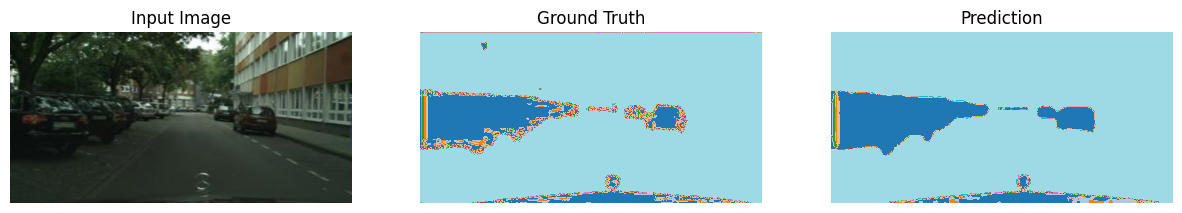

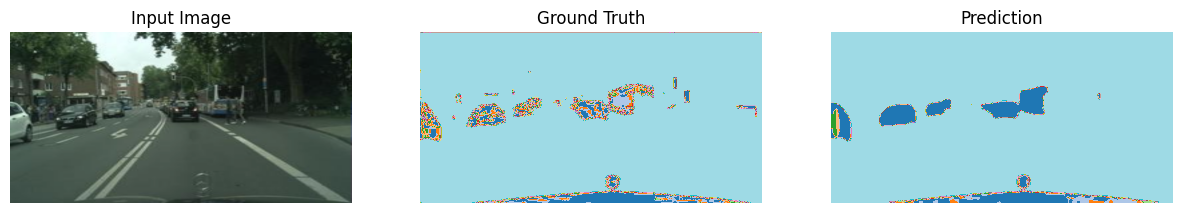

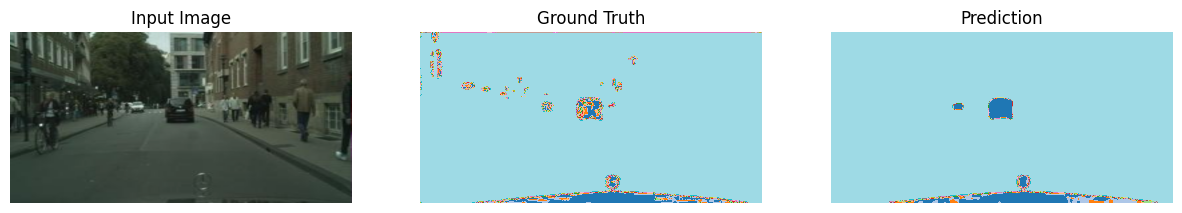

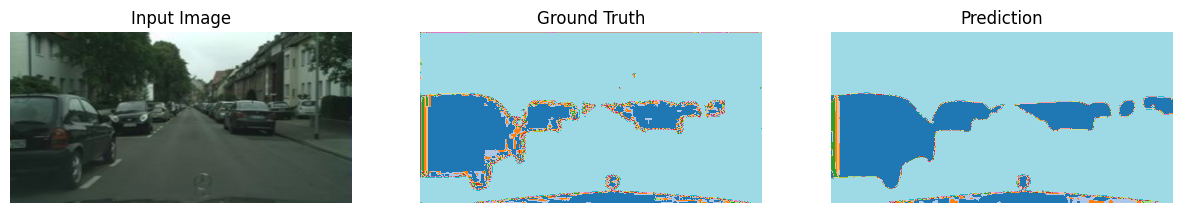

In [ ]:
i = 0
for input_tensor, mask_tensor in val_loader:
    i = i + 1
    if i < 5:
        input_tensor = input_tensor.to(device)
        with torch.no_grad():
            output = model(input_tensor)['out']
        pred_tensor = torch.argmax(output.squeeze(), dim=0).cpu()
        visualize_prediction(input_tensor[0].cpu(), mask_tensor[0], pred_tensor)


In [ ]:
from PIL import Image
import torchvision.transforms as transforms

# Set image path
custom_img_path = "/kaggle/input/picture-01/free-photo-of-cars-parked-on-street-in-city.jpeg"  # Replace with actual filename

# Load and preprocess the image
image = Image.open(custom_img_path).convert("RGB")

# Match preprocessing used in training
preprocess = transforms.Compose([
    transforms.Resize((384, 768)),  # Same as training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

input_tensor = preprocess(image).unsqueeze(0).to(device)  # Add batch dim


In [ ]:
model.eval()
with torch.no_grad():
    output = model(input_tensor)['out']
    pred = torch.argmax(output.squeeze(), dim=0).cpu()


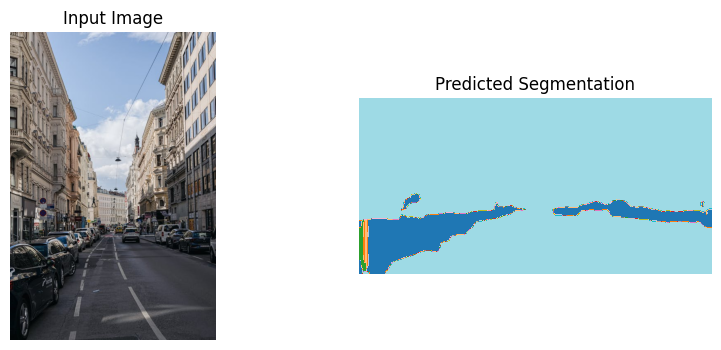

In [ ]:
import matplotlib.pyplot as plt

def visualize_custom(original_image, pred_tensor):
    # Convert original PIL image to NumPy without normalization
    input_img = np.array(original_image)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(input_img)
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(pred_tensor, cmap='tab20')
    plt.title("Predicted Segmentation")
    plt.axis('off')
    plt.show()


visualize_custom(image, pred)


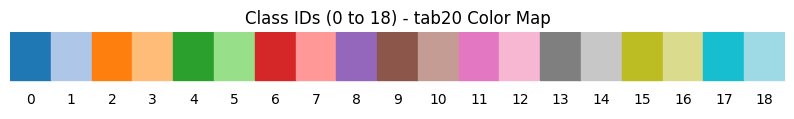

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_tab20_colormap(num_classes=19):
    cmap = plt.get_cmap('tab20')
    colors = cmap(np.linspace(0, 1, num_classes))

    fig, ax = plt.subplots(figsize=(10, 1))
    for i in range(num_classes):
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=colors[i]))
        ax.text(i + 0.5, -0.4, str(i), ha='center', va='center', fontsize=10)
    ax.set_xlim(0, num_classes)
    ax.set_ylim(-0.6, 1)
    ax.axis('off')
    plt.title("Class IDs (0 to 18) - tab20 Color Map")
    plt.show()

show_tab20_colormap()


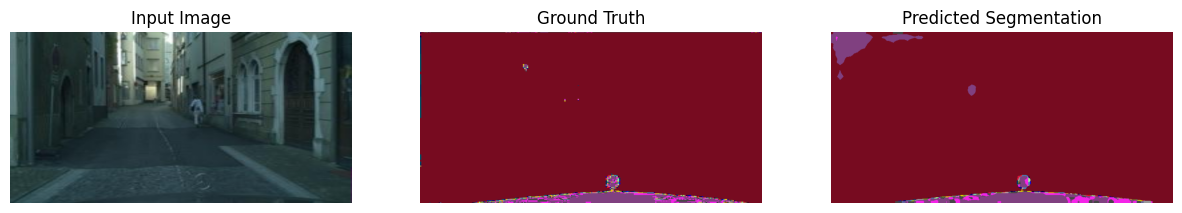

In [ ]:
# Cityscapes class names (19 classes)
CITYSCAPES_CLASSES = [
    "road", "sidewalk", "building", "wall", "fence", "pole", "traffic light",
    "traffic sign", "vegetation", "terrain", "sky", "person", "rider",
    "car", "truck", "bus", "train", "motorcycle", "bicycle"
]

# Corresponding RGB colors (official Cityscapes palette)
CITYSCAPES_COLORS = [
    (128, 64,128), (244, 35,232), ( 70, 70, 70), (102,102,156), (190,153,153),
    (153,153,153), (250,170, 30), (220,220,  0), (107,142, 35), (152,251,152),
    ( 70,130,180), (220, 20, 60), (255,  0,  0), (  0,  0,142), (  0,  0, 70),
    (  0, 60,100), (  0, 80,100), (  0,  0,230), (119, 11, 32)
]


import numpy as np

def decode_segmap(pred_mask):
    """Converts class ID mask to RGB image using Cityscapes colors"""
    h, w = pred_mask.shape
    rgb_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_id in range(len(CITYSCAPES_COLORS)):
        rgb_mask[pred_mask == class_id] = CITYSCAPES_COLORS[class_id]
    return rgb_mask


def visualize_cityscapes(input_tensor, pred_tensor, mask_tensor=None):
    input_img = input_tensor.permute(1, 2, 0).cpu().numpy()
    input_img = input_img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    input_img = (input_img * 255).astype("uint8")

    pred_rgb = decode_segmap(pred_tensor.numpy())

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2 if mask_tensor is None else 3, 1)
    plt.imshow(input_img)
    plt.title("Input Image")
    plt.axis('off')

    if mask_tensor is not None:
        gt_rgb = decode_segmap(mask_tensor.numpy())
        plt.subplot(1, 3, 2)
        plt.imshow(gt_rgb)
        plt.title("Ground Truth")
        plt.axis('off')

        plt.subplot(1, 3, 3)
    else:
        plt.subplot(1, 2, 2)

    plt.imshow(pred_rgb)
    plt.title("Predicted Segmentation")
    plt.axis('off')
    plt.show()

with torch.no_grad():
    for input_tensor, mask_tensor in val_loader:
        input_tensor = input_tensor.to(device)
        output = model(input_tensor)['out']
        pred = torch.argmax(output.squeeze(), dim=0).cpu()

        visualize_cityscapes(input_tensor[0].cpu(), pred, mask_tensor[0])
        break


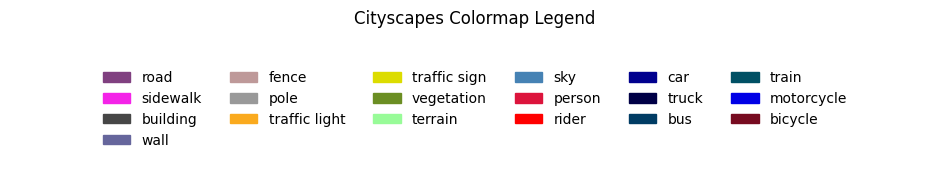

In [ ]:
import matplotlib.patches as mpatches

def show_cityscapes_legend():
    plt.figure(figsize=(12, 2))
    handles = []
    for label, color in zip(CITYSCAPES_CLASSES, CITYSCAPES_COLORS):
        patch = mpatches.Patch(color=np.array(color)/255.0, label=label)
        handles.append(patch)
    plt.legend(handles=handles, loc='center', ncol=6, frameon=False)
    plt.axis('off')
    plt.title("Cityscapes Colormap Legend")
    plt.show()

show_cityscapes_legend()


In [ ]:
print(torch.unique(mask_tensor))
